# Model Training and Evaluation

This notebook loads the pre-computed features, trains multiple models, and selects the best one for production.

In [1]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline

%matplotlib inline

## 1. Load Features

In [2]:
try:
    X = joblib.load("../models/X_features.joblib")
    y = joblib.load("../models/y_labels.joblib")
    print(f"Loaded X: {X.shape}, y: {y.shape}")
except FileNotFoundError:
    print("Features not found. Please run 02_feature_engineering_and_segmentation.ipynb first.")

Loaded X: (1656, 224), y: (1656,)


## 2. Train/Test Split

In [3]:
# 70% Train, 15% Val, 15% Test
# First split: Train+Val (85%) and Test (15%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)

# Second split: Train (approx 70% of total -> 0.7/0.85 = 0.82 of temp) and Val
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, stratify=y_temp, random_state=42)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (1159, 224), Val: (248, 224), Test: (249, 224)


## 3. Model Selection

In [4]:
models = {
    "LogisticRegression": Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(class_weight='balanced', max_iter=1000))
    ]),
    "RandomForest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100, max_depth=3, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)

    # Evaluate on Validation set
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)[:, 1]

    roc = roc_auc_score(y_val, y_prob)
    print(f"{name} Val ROC-AUC: {roc:.4f}")

    results[name] = {
        "model": model,
        "roc": roc,
        "y_pred": y_pred,
        "y_prob": y_prob
    }

Training LogisticRegression...
LogisticRegression Val ROC-AUC: 0.9883
Training RandomForest...
RandomForest Val ROC-AUC: 0.9987
Training GradientBoosting...
GradientBoosting Val ROC-AUC: 0.9963


## 4. Select Best Model

In [5]:
best_name = max(results, key=lambda k: results[k]['roc'])
best_model = results[best_name]['model']
print(f"Best Model: {best_name}")

Best Model: RandomForest


## 5. Final Evaluation on Test Set

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97        99
           1       0.97      0.99      0.98       150

    accuracy                           0.98       249
   macro avg       0.98      0.97      0.97       249
weighted avg       0.98      0.98      0.98       249

Test ROC-AUC: 0.9978


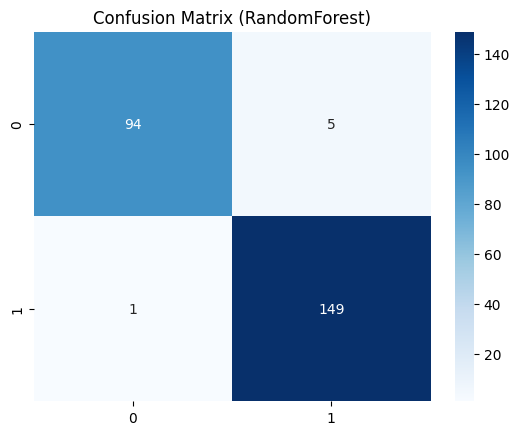

In [6]:
y_test_pred = best_model.predict(X_test)
y_test_prob = best_model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_test_pred))

print(f"Test ROC-AUC: {roc_auc_score(y_test, y_test_prob):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix ({best_name})')
plt.show()

## 6. Save Model

In [7]:
joblib.dump(best_model, "../models/eeg_best_model.joblib")
print("Model saved to ../models/eeg_best_model.joblib")

Model saved to ../models/eeg_best_model.joblib
